# Tutorial 2. Machine Learning with Python
In this tutorial, we will learn how train a model with python.

## 1. Prepare Data for ML

In [1]:
from pathlib import Path
from datetime import datetime

import numpy as np
import rasterio as rio

### 1.1 Merge necessary bands and save as tif
- **B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12** (bands from zip)
- **SCL** (processing from scene_classification_map)
- **ROWS, COLS** (calculate pixel index in array)

In [2]:
scl_classes = {
  0: [0, 0, 0],        # No Data (Missing data) - black  
  1: [255, 0, 0],      # Saturated or defective pixel - red 
  2: [47, 47, 47],     # Topographic casted shadows ("Dark features/Shadows" for data before 2022-01-25) - very dark grey
  3: [100, 50, 0],     # Cloud shadows - dark brown
  4: [0, 160, 0],      # Vegetation - green
  5: [255, 230, 90],   # Not-vegetated - dark yellow
  6: [0, 0, 255],      # Water (dark and bright) - blue
  7: [128, 128, 128],  # Unclassified - dark grey
  8: [192, 192, 192],  # Cloud medium probability - grey
  9: [255, 255, 255],  # Cloud high probability - white
  10: [100, 200, 255], # Thin cirrus - very bright blue
  11: [255, 150, 255], # Snow or ice - very bright pink
}

bands =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'classification']

In [3]:
def merge_bands(tif_folder: Path, output_tif_fp: Path):
    dict_img = dict()
        
    # glob all file in folder
    for tif_fp in tif_folder.glob('*.tiff'):
            
        # extract necessory band
        for band in bands:
            if band not in tif_fp.stem:
                continue
            dict_img[band] = rio.open(tif_fp)
    
    # read array
    tif_data = []
    for band in bands[:-1]:
        tif_data.append(dict_img[band].read())

    # convert scl array from 3 bands to 1 band
    rst_scl = dict_img['classification']
    arr_scl_rgb = rst_scl.read().astype(float)
    
    # create empty array with the same shape of tif
    h, w = rst_scl.shape
    arr_scl = np.empty((h, w))

    # assign new value to the empty array
    for value, (r, g, b) in scl_classes.items():
        condition = np.where(
            (abs(arr_scl_rgb[0] - r) <= 1) & 
            (abs(arr_scl_rgb[1] - g) <= 1) & 
            (abs(arr_scl_rgb[2] - b) <= 1)
        )
        arr_scl[condition] = value
    tif_data.append(arr_scl.reshape(1, h, w))

    # add row index and col index
    row_vals, col_vals = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    arr_row_col = np.stack((row_vals, col_vals), axis=-1).transpose([2,0,1])
    tif_data.append(arr_row_col)
    tif_arr = np.concatenate(tif_data)

    # write tif metadata
    profile = rst_scl.profile
    profile.update(
        dict(
            count=tif_arr.shape[0],
            compress='lzw',
            dtype=rio.uint16,
        )
    )

    # export tif
    with rio.open(output_tif_fp, 'w', **profile) as dst:
        dst.write(tif_arr)
        dst.descriptions = tuple(bands[:-1] + ['SCL', 'ROWS', 'COLS'])

In [4]:
sentinel2_folder = Path('data/sentinel-2/')

# create folder to save tif file
Path('data/tif').mkdir(exist_ok=True)

# use  to get tif_folder
for tif_folder in sentinel2_folder.iterdir():
    if not tif_folder.is_dir():
        continue
    t = datetime.fromisoformat(f'{tif_folder.stem}T00:00:00+00:00')
    merge_bands(tif_folder, Path(f'data/tif/{t:%Y-%m-%d}.tif'))
    print(f'Merge {t} done.')
print('All finished')

Merge 2023-01-25 00:00:00+00:00 done.
Merge 2023-01-30 00:00:00+00:00 done.
Merge 2023-03-01 00:00:00+00:00 done.
Merge 2023-03-06 00:00:00+00:00 done.
Merge 2023-07-04 00:00:00+00:00 done.
Merge 2023-11-06 00:00:00+00:00 done.
Merge 2023-11-21 00:00:00+00:00 done.
Merge 2023-11-26 00:00:00+00:00 done.
Merge 2024-01-15 00:00:00+00:00 done.
Merge 2024-02-14 00:00:00+00:00 done.
Merge 2024-03-15 00:00:00+00:00 done.
Merge 2024-04-04 00:00:00+00:00 done.
All finished


### 1.2 Convert 2023's tif into training data
> pandas: https://pandas.pydata.org/

#### 1.2.1 Do normalization

Clip min and max value and normalized to 0 ~ 1.

In [5]:
def norm(arr, clip=[0.01,0.99]):
    arr_copy = arr.copy()
    tmp = np.sort(arr_copy.flatten())
    tmp = tmp[tmp >= 0]
    
    new_min = tmp[int(len(tmp)*clip[0])]
    if clip[1] >= 1:
        new_max = tmp[-1]
    else:
        new_max = tmp[int(len(tmp)*clip[1])]

    arr_copy[arr_copy < new_min] = new_min
    arr_copy[arr_copy > new_max] = new_max
    
    return (arr_copy - np.nanmin(arr_copy)) / (np.nanmax(arr_copy) - np.nanmin(arr_copy))

### 1.2.2 Find label

- True: The pixel that overlap label shp and the SCL is not cloud or none (0, 3, 8, 9).
- False: Other pixel

In [6]:
import geopandas as gpd
import rasterio.mask as rmask

def filter_with_cloud_and_label(rst: rio.io.DatasetReader, gdf_label: gpd.GeoDataFrame):
    """
    return mask contain cloud and not label
    """
    bands = list(rst.descriptions)
    scl_idx = bands.index('SCL')

    masked_arr, gt = rmask.mask(rst, gdf_label.to_crs(rst.crs.to_epsg())['geometry'].values, all_touched=True)
    return (masked_arr[scl_idx] == 0) | (masked_arr[scl_idx] == 3) | (masked_arr[scl_idx] == 8) | (masked_arr[scl_idx] == 9)  

In [7]:
import pandas as pd

tmp = []
gdf = gpd.read_file('data/shapefile/label.shp')

for tif_fp in Path('data/tif').glob('2023*.tif'):
    rst = rio.open(tif_fp)
    h, w = rst.shape
    bands_num = rst.count
    arr = rst.read()
    
    # convert array to dataframe
    df = pd.DataFrame(arr.reshape([bands_num, h*w]).T, columns=rst.descriptions, dtype=float)

    # normalize b01 ~ b12's data
    df.iloc[:,:12] = norm(arr[:12]).reshape([12, h*w]).T

    # calculate mask and add to label
    arr_mask = filter_with_cloud_and_label(rst, gdf)
    df['label'] = ~arr_mask.reshape(h*w)

    # note value source
    df['frame'] = tif_fp.stem
    tmp.append(df)
    print(f'convert {tif_fp.stem} done.')

df = pd.concat(tmp).reset_index(drop=True)
df

convert 2023-01-25 done.
convert 2023-01-30 done.
convert 2023-03-01 done.
convert 2023-03-06 done.
convert 2023-07-04 done.
convert 2023-11-06 done.
convert 2023-11-21 done.
convert 2023-11-26 done.


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,SCL,ROWS,COLS,label,frame
0,0.069959,0.074074,0.082305,0.061728,0.053498,0.024691,0.024691,0.024691,0.020576,0.004115,0.008230,0.004115,6.0,0.0,0.0,False,2023-01-25
1,0.069959,0.069959,0.078189,0.057613,0.053498,0.024691,0.024691,0.020576,0.020576,0.004115,0.008230,0.004115,6.0,0.0,1.0,False,2023-01-25
2,0.069959,0.074074,0.082305,0.061728,0.053498,0.024691,0.024691,0.024691,0.016461,0.004115,0.004115,0.004115,6.0,0.0,2.0,False,2023-01-25
3,0.069959,0.069959,0.078189,0.057613,0.053498,0.024691,0.024691,0.020576,0.020576,0.004115,0.004115,0.004115,6.0,0.0,3.0,False,2023-01-25
4,0.069959,0.074074,0.082305,0.065844,0.057613,0.028807,0.024691,0.028807,0.020576,0.004115,0.008230,0.004115,6.0,0.0,4.0,False,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32199995,0.040650,0.048780,0.097561,0.040650,0.170732,0.682927,0.886179,0.918699,0.951220,0.926829,0.398374,0.162602,4.0,1609.0,2495.0,False,2023-11-26
32199996,0.040650,0.056911,0.105691,0.048780,0.203252,0.715447,0.967480,0.943089,1.000000,0.934959,0.406504,0.170732,4.0,1609.0,2496.0,False,2023-11-26
32199997,0.040650,0.048780,0.097561,0.040650,0.178862,0.691057,0.853659,0.886179,0.991870,0.934959,0.398374,0.162602,4.0,1609.0,2497.0,False,2023-11-26
32199998,0.048780,0.048780,0.097561,0.040650,0.170732,0.691057,0.934959,0.886179,1.000000,0.926829,0.406504,0.170732,4.0,1609.0,2498.0,False,2023-11-26


In [8]:
df_true = df[df['label'] == True]
df_false = df[(df['label'] == False)&(df['SCL']!=0)&(df['SCL']!=3)&(df['SCL']!=8)&(df['SCL']!=9)]
print(f'before_balance, true = {len(df_true)}, false = {len(df_false)}')

df_datasets = pd.concat([df_true, df_false.sample(len(df_true))]).reset_index(drop=True)
df_datasets

before_balance, true = 1338222, false = 29574862


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,SCL,ROWS,COLS,label,frame
0,0.061728,0.053498,0.069959,0.086420,0.123457,0.164609,0.181070,0.189300,0.209877,0.172840,0.222222,0.156379,5.0,0.0,377.0,True,2023-01-25
1,0.049383,0.049383,0.061728,0.074074,0.115226,0.168724,0.193416,0.209877,0.226337,0.176955,0.205761,0.127572,5.0,0.0,378.0,True,2023-01-25
2,0.049383,0.045267,0.061728,0.065844,0.102881,0.185185,0.205761,0.234568,0.234568,0.201646,0.176955,0.111111,5.0,0.0,379.0,True,2023-01-25
3,0.049383,0.049383,0.065844,0.069959,0.102881,0.164609,0.185185,0.209877,0.213992,0.193416,0.181070,0.115226,5.0,0.0,380.0,True,2023-01-25
4,0.045267,0.041152,0.057613,0.065844,0.086420,0.123457,0.139918,0.172840,0.160494,0.172840,0.156379,0.094650,5.0,0.0,381.0,True,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676439,0.061069,0.068702,0.129771,0.106870,0.236641,0.519084,0.610687,0.671756,0.671756,0.648855,0.427481,0.244275,4.0,316.0,825.0,False,2023-11-21
2676440,0.164948,0.185567,0.164948,0.072165,0.061856,0.041237,0.041237,0.030928,0.030928,0.020619,0.010309,0.000000,6.0,516.0,126.0,False,2023-03-01
2676441,0.045802,0.022901,0.053435,0.030534,0.099237,0.358779,0.458015,0.435115,0.488550,0.595420,0.160305,0.068702,4.0,905.0,2352.0,False,2023-11-21
2676442,0.206186,0.144330,0.144330,0.144330,0.175258,0.226804,0.226804,0.030928,0.216495,0.721649,0.185567,0.144330,2.0,312.0,2400.0,False,2023-03-01


### 1.3 Split to train_set and valid_set
> lightgbm: https://lightgbm.readthedocs.io/en/stable/  
> scikit-learn: https://scikit-learn.org/stable/

In [9]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_datasets.iloc[:,0:12], 
    df_datasets.loc[:,'label'], 
    test_size=0.1, 
    random_state=2024, 
    shuffle=True
)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

## 2. Training

In [10]:
params = {
    "objective": "binary",
    "metric": ["binary_error","l1","l2"],
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Trees
    # 'num_leaves': 31,                # Maximum number of leaves in one tree
    'learning_rate': 1e-6,           # Learning rate
    'feature_fraction': 0.9,         # Randomly select a fraction of features for training each tree
}

callbacks = [
    lgb.log_evaluation(period=100), 
    # lgb.early_stopping(stopping_rounds=50)
]

In [11]:
bst = lgb.train(
    params, 
    train_data, 
    valid_sets=[train_data, val_data], 
    num_boost_round=1000,
    callbacks=callbacks
)

[LightGBM] [Info] Number of positive: 1204418, number of negative: 1204381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 2408799, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031
[100]	training's binary_error: 0.125294	training's l1: 0.499969	training's l2: 0.249969	valid_1's binary_error: 0.12545	valid_1's l1: 0.499969	valid_1's l2: 0.249969
[200]	training's binary_error: 0.126121	training's l1: 0.499937	training's l2: 0.249937	valid_1's binary_error: 0.126459	valid_1's l1: 0.499937	valid_1's l2: 0.249937
[300]	training's binary_error: 0.125237	training's l1: 0.499906	training's l2: 0.249906	valid_1's binary_

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

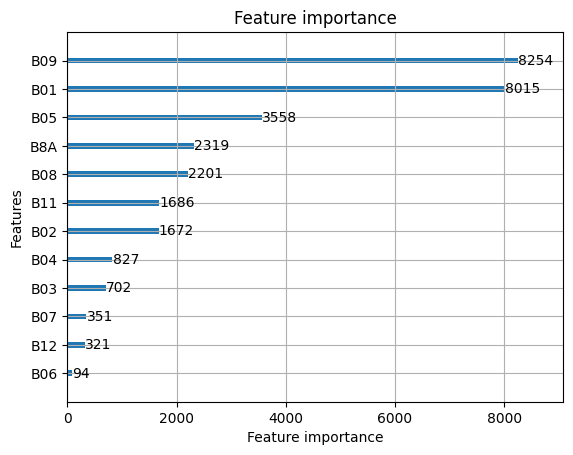

In [12]:
lgb.plot_importance(bst, max_num_features=12)

In [13]:
Path('data/weights').mkdir(exist_ok=True)
bst.save_model('model.txt')

## 3. Predict

### 3.1 Load model and do predict

In [14]:
model = lgb.Booster(model_file='data/weights/model.txt')
prob = model.predict(X_val)
res = np.where(prob>=0.5,1,0)
df_predict = pd.DataFrame(np.array([prob, res, y_val]).T, columns=['prob', 'predict', 'label'])
df_predict

,prob,predict,label
0,0.499697,0.0,1.0
1,0.499533,0.0,0.0
2,0.500368,1.0,1.0
3,0.499519,0.0,0.0
4,0.500454,1.0,1.0
...,...,...,...
267640,0.499858,0.0,1.0
267641,0.500316,1.0,1.0
267642,0.499815,0.0,1.0
267643,0.500176,1.0,1.0


### 3.2 Analysis result

In [15]:
TP = len(df_predict[(df_predict['predict'] == 1) & (df_predict['label'] == 1)])
TN = len(df_predict[(df_predict['predict'] == 0) & (df_predict['label'] == 0)])
FP = len(df_predict[(df_predict['predict'] == 1) & (df_predict['label'] == 0)])
FN = len(df_predict[(df_predict['predict'] == 0) & (df_predict['label'] == 1)])
Total = len(df_predict)

print(f'TP = {TP/Total*100:.2f}%\nTN = {TN/Total*100:.2f}%\nFP = {FP/Total*100:.2f}%\nFN = {FN/Total*100:.2f}%\nAcc = {(TP+TN)/Total*100:.2f}%')

TP = 44.25%
TN = 43.39%
FP = 6.62%
FN = 5.74%
Acc = 87.64%


### 3.3 Predict entire image

### 3.3.1 Convert tif to dataframe

In [16]:
rst = rio.open('data/tif/2024-02-14.tif')
h, w = rst.shape
bands_num = rst.count
arr = rst.read()
df = pd.DataFrame(arr.reshape([bands_num, h*w]).T, columns=rst.descriptions, dtype=float)
df.iloc[:,:12] = norm(arr[:12]).reshape([12, h*w]).T
df

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,SCL,ROWS,COLS
0,0.084906,0.103774,0.094340,0.018868,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,0.0
1,0.084906,0.103774,0.084906,0.018868,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,1.0
2,0.084906,0.103774,0.084906,0.028302,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,2.0
3,0.084906,0.103774,0.094340,0.028302,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,3.0
4,0.084906,0.103774,0.084906,0.018868,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4024995,0.301887,0.254717,0.301887,0.273585,0.396226,0.726415,0.867925,0.877358,0.943396,0.95283,0.613208,0.481132,4.0,1609.0,2495.0
4024996,0.377358,0.330189,0.386792,0.386792,0.500000,0.839623,0.981132,0.990566,1.000000,1.00000,0.735849,0.632075,4.0,1609.0,2496.0
4024997,0.452830,0.415094,0.462264,0.462264,0.575472,0.896226,1.000000,1.000000,1.000000,1.00000,0.820755,0.707547,5.0,1609.0,2497.0
4024998,0.528302,0.481132,0.518868,0.509434,0.622642,0.952830,1.000000,1.000000,1.000000,1.00000,0.886792,0.783019,5.0,1609.0,2498.0


### 3.3.2 Predict

In [17]:
p = model.predict(df.iloc[:,:12])
res = np.where(p>=0.5, 1, 0)

### 3.3.3 Plot predict result

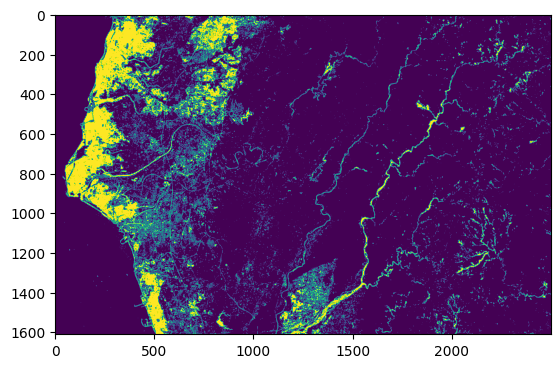

In [18]:
import matplotlib.pyplot as plt

plt.imshow(res.reshape([h, w]))